# Introduction to Time series

We first see here which specific characteristics the Time Series (TS) have, and will then see in a second part a concrete example of TS analysis (smoothing + modelling + forecasting).

Stochastic vs. deterministic model  

In a deterministic process you know exactly where the next point is, in the stochastic process there is some randomness at every point.

## A deterministic process

In a deterministic process you know exactly where the next point is.  
For example, the sine wave function:

In [1]:
import pandas as pd
import numpy as np

np.random.seed(2018)

In [2]:
n = 100
x = np.linspace(0, 2 * np.pi, n)
y = np.sin(x)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

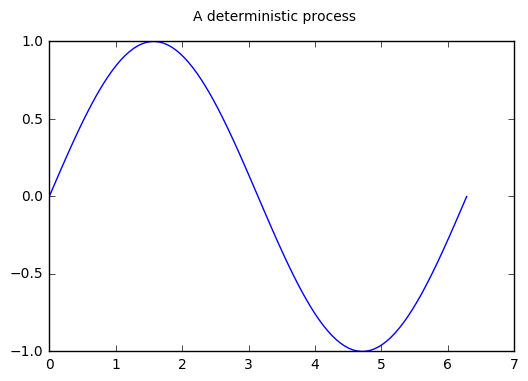

In [4]:
fig,ax = plt.subplots()
ax.plot(x,y)
fig.suptitle("A deterministic process")

## A stochastic process

In the stochastic process there is some randomness at every point.  
While a purely random process, e.g. the white noise, where every step is randomly taken from a normal distribution,  is an example of stochastic process:

In [5]:
whiteNoise = np.random.standard_normal(100) # normal distribution mean=0, std=1

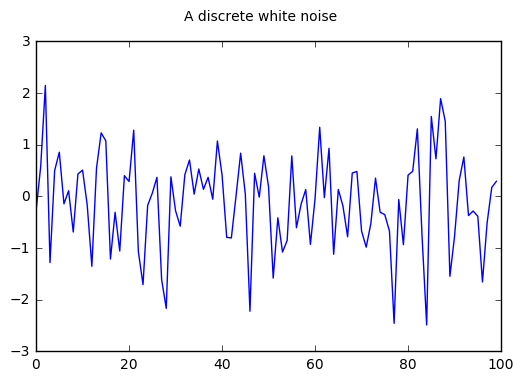

In [6]:
fig,ax = plt.subplots()
ax.plot(whiteNoise)
fig.suptitle("A discrete white noise")

As you see, it is basically impossible to predict the value of the next step.  
Assuming that our time series are a realisation of a stochastic  process (a sequence of random variables) will allow us to predict the next data points of the time series. That is, we are going to assume that there is some underlying generating process for our time series.  
Let's see another example: we inject some randomness into the above sine wave:

In [7]:
n = 100
x = np.linspace(0, 2 * np.pi, n)
noisyWave = np.sin(x) + 0.3 * np.random.randn(n)

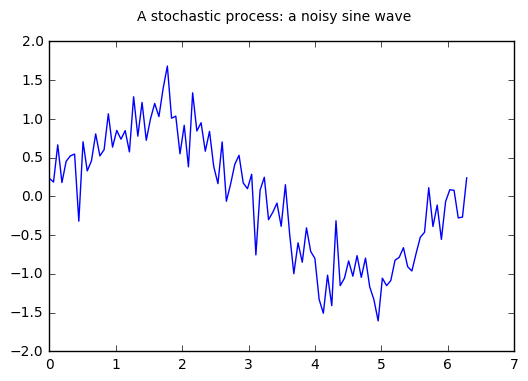

In [8]:
fig,ax = plt.subplots()
ax.plot(x,noisyWave)
fig.suptitle("A stochastic process: a noisy sine wave")

There is randomness and we cannot say exactly where the next point will be but we can also see that there is an underlying generating process, the sine wave.

# Stationarity
In a stationary time series , there is   
- no systematic change in mean (no trend)
- no systematic change in variance
- no periodic variations

For a non-stationary time series, we will do some transformations to get stationary time series.  

But why is this important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.

## Signal or noise?



One of the challenge is then to extract signal from noise.
The autocorrelation will help us.
Let's see it in details.

The covariance of two random variables x and y,  tells us how the two variables move together. Measures the linear dependence between two random variables:

In [9]:
def getCovariance(x, y):
    # returns the covariance of two data sets
    
        # Subtract the subseries means
    return np.dot((x-np.mean(x)), (y-np.mean(y))) / len(x)

In [10]:
getCovariance([1,2,3], [1,2,3])

0.66666666666666663

Auto means self and the autocovariance is the covariance of X with a lagged version of itself:

If the signal is weakly stationary, it means that this autocorrelation is constant over time.
And because of that, it means that we can use the data to create a sample version of the autocorrelation. We just take subsequents slices (the samples) of the data series.

In [11]:
def getAutoCovariance(x, lag):
    # return the covariance of one data set by 
    # slicing it based on the given lag
    
        # slice into two sub sets
    x1 = x[:(len(x)-lag)] # from begin till (end-lag)
    x2 = x[lag:]  # from lag till the end
    
        # get the covariance of the two sub-sets
    covariance = getCovariance(x1, x2)
    
        # return the covariance but also the 
        # standard deviations of the two subsets
    return (covariance, np.std(x1), np.std(x2))

In [12]:
getAutoCovariance([1,2,3,4], lag=2)

(0.25, 0.5, 0.5)

In [13]:
def autocorrelation_var(x, lag):
      # get the covariance by slicing
    (covariance, _, _) = getAutoCovariance(x, lag)

      # Normalize with variance of whole series
    return covariance /  np.var(x)

def autocorrelation_std(x, lag):    
         # get the covariance by slicing   
    (covariance, std_x1, std_x2) = getAutoCovariance(x, lag)

        # Normalize with the subseries standard deviations
    return covariance / (std_x1 * std_x2)

In [14]:
import statsmodels.tsa.stattools as smt

/Users/Massimo/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
results = {}
nlags=20
results["Slices_variance"] = [autocorrelation_var(whiteNoise, lag) for lag in range(nlags)]
results["Slices_Std"] = [autocorrelation_std(whiteNoise, lag) for lag in range(nlags)]
results["Pandas"] = [pd.Series(whiteNoise).autocorr(lag) for lag in range(nlags)]
results["Statmodels"] = smt.acf(whiteNoise, unbiased=True, nlags=nlags-1)

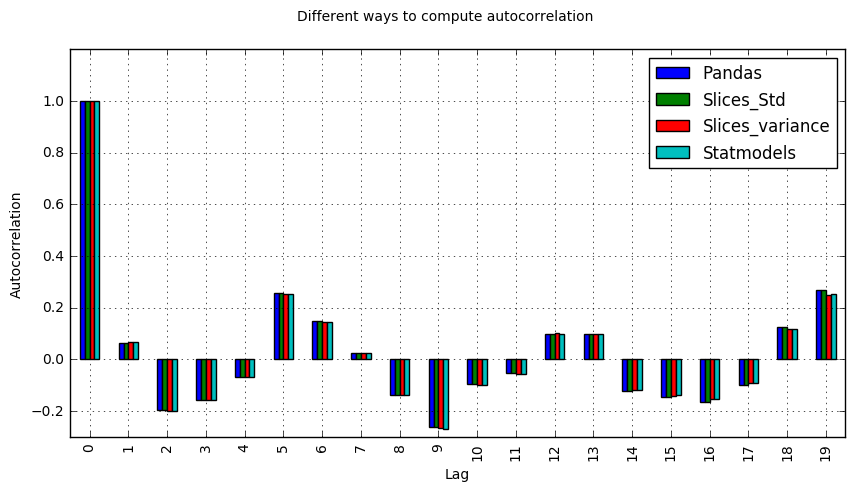

In [16]:
pd.DataFrame(results).plot(kind="bar", figsize=(10,5), grid=True)
plt.xlabel("Lag")
plt.ylim([-0.3, 1.2])
plt.ylabel("Autocorrelation")
plt.suptitle("Different ways to compute autocorrelation")
plt.show()

Pandas is using the variance, while statsmodels is using the std.

### The correlogram


Statmodels return more information :

In [17]:
data_acf, ci, Q, pValue = smt.acf(whiteNoise, qstat=True, alpha=0.05)

and it provides useful plots:

In [18]:
import statsmodels.graphics.tsaplots as smpl

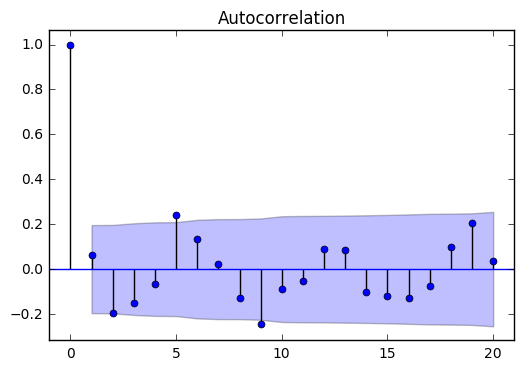

In [19]:
smpl.plot_acf(whiteNoise, lags=20);

Let's see an example where every point is correlated with the previous one: a sequence.

In [20]:
sequence1 = np.arange(0, 1, 1/100)  # a sequence from 0 to 1 by 1/100

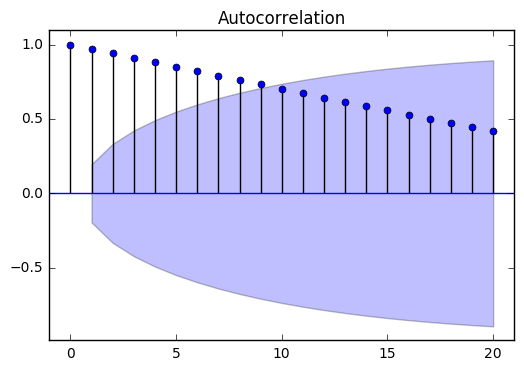

In [21]:
smpl.plot_acf(sequence1, lags=20);

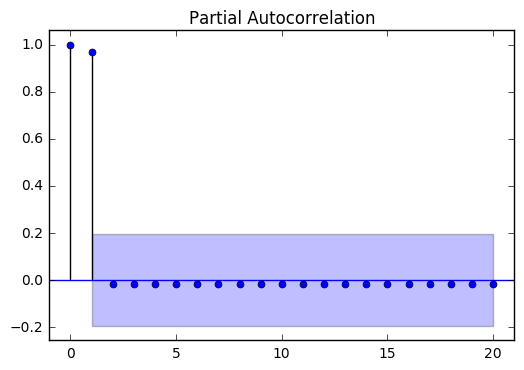

In [22]:
smpl.plot_pacf(sequence1, lags=20);

In [23]:
sequence2 = np.array([1,2,3])
sequence2 = np.resize(sequence2, 21) # repeat it 7 times

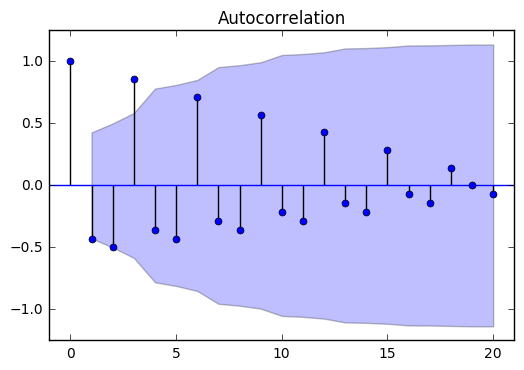

In [24]:
smpl.plot_acf(sequence2, lags=20);

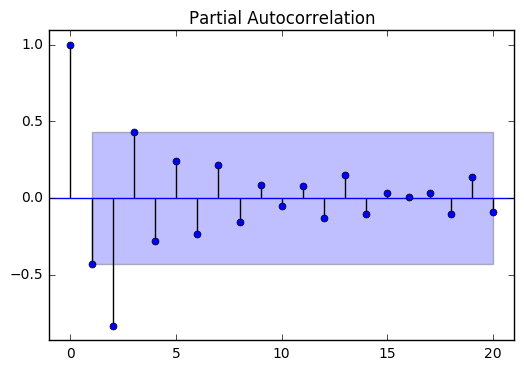

In [25]:
smpl.plot_pacf(sequence2, lags=20);

## White noise

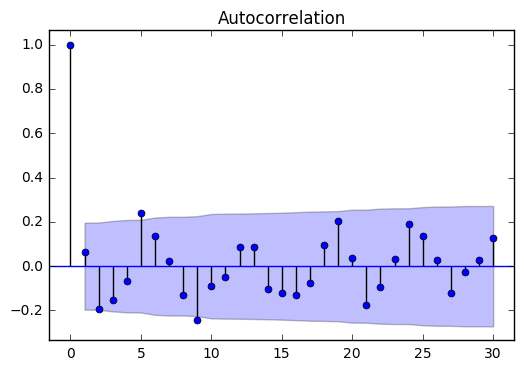

In [26]:
smpl.plot_acf(whiteNoise, lags=30);

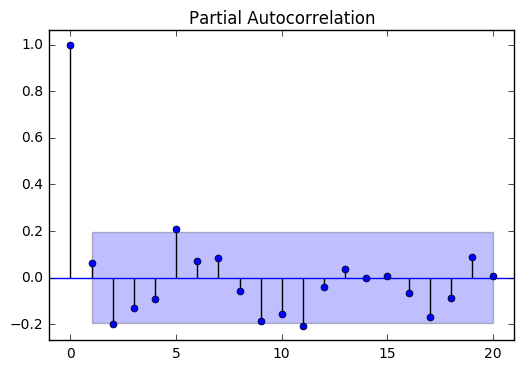

In [27]:
smpl.plot_pacf(whiteNoise, lags=20);

/Users/Massimo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  app.launch_new_instance()


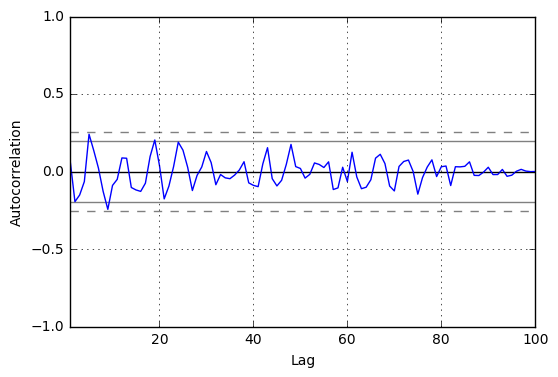

In [28]:
from pandas.tools.plotting import autocorrelation_plot
wnS = pd.Series(whiteNoise)
autocorrelation_plot(wnS)

# Random Walk

A random walk is a stationary stochastic process. Not a time series.    
Its model relates current value of the time series to the previous value by adding some random deviation to the previous value.  
A random walk model: X_t = X_t-1 + Z_t  
Z_t is the white noise (residual).

In [29]:
def plotTS(y, lags=None, style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure()
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smpl.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smpl.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
    return 

In [30]:
SAMPLES = 1000
Z = np.random.normal(size = SAMPLES)
rw = np.zeros(SAMPLES)

for t in range(SAMPLES):
    rw[t] = rw[t-1] + Z[t]

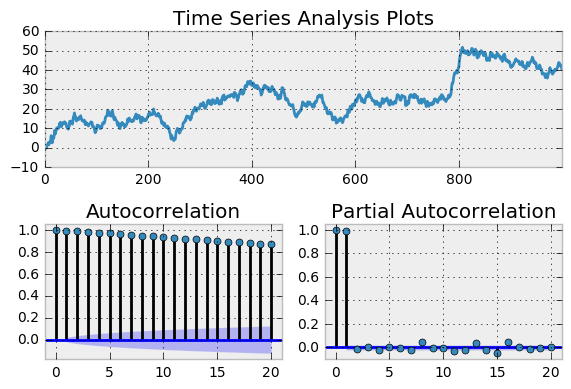

In [31]:
plotTS(rw, lags=20);

Clearly our random walk is not stationary.  
Recall that a random walk is X_t = X_t-1 + Z_t. Using algebra we can say that X_t - Xt-1 = Z_t. Thus the first differences of our random walk series should equal a white noise process!  
We can use the "np.diff()" function on our TS and see if this holds. 

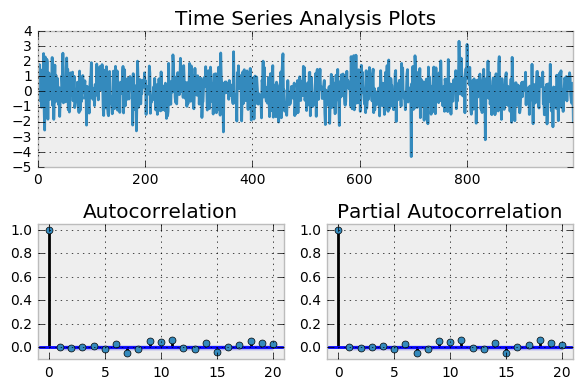

In [32]:
plotTS(np.diff(rw), lags=20);

Our definition holds as this looks exactly like a white noise process. 

Applying the difference to a Time Series is one way to remove the trend; this will get a stationary time series from a random walk.  
Let's see more ways to extract the trend from a Time Series.

# Extract the Trend

One of the basic information we want to see in a time series is if it has a trend and how it looks like.  
Let's get back to our noisy sine wave: 

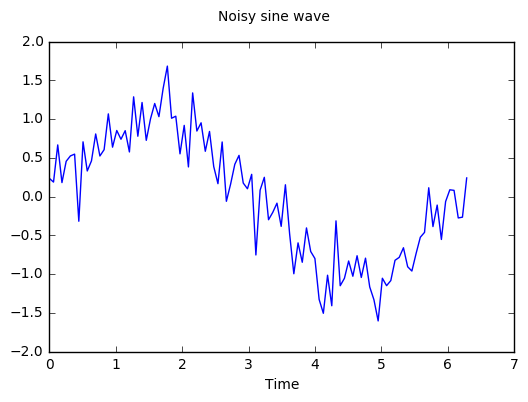

In [33]:
fig,ax = plt.subplots()
ax.plot(x,noisyWave)
ax.set_xlabel("Time")
fig.suptitle("Noisy sine wave")

We know that there is a trend (because of how it has been built) but how to extract the trend?

One way to get the trend is to use regression, basically a local regression.  

You define a window of width m and then you just average the previous m values to get a smooth estimate for the current time. And then we continue to move over, use the next m values to get the estimate for the next point and so on.

This is called moving average  and is used to get a fine trend (it's basically a low-pass filter). 

To get a higher level trend, a method called Loess can be used. It still defines a window and uses the nearest neighbours that are within that window to do the local regression. But The loess regression uses polynomial terms:
((1-distance(t,t_0)^3)^3.  
Higher weights for the nearer points.    

## Moving average



In [34]:
def movingAverage(values, order):
    # perform local regression on "values" using moving windows of width "order"
    end = len(values)
    out = np.zeros(len(values))
    
    out[0] = values[1]
    for i in range(1,end):
        if (i - order <= 1):
            j = 1
        else:
            j += 1
        out[i] = sum(values[j-1:i]) / (i-j+1)
        
    return out

Let's try with a window of width 10:

In [35]:
trendMA = movingAverage(noisyWave,10)

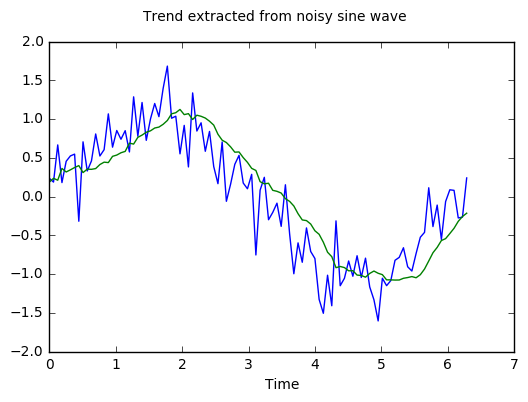

In [36]:
fig,ax = plt.subplots()
ax.plot(x,noisyWave)
ax.plot(x,trendMA)
ax.set_xlabel("Time")
fig.suptitle("Trend extracted from noisy sine wave")

The Loess regression is more complicated but there is a function for it in the statsmodels package:

In [37]:
import statsmodels.nonparametric.smoothers_lowess as smL

trendL = smL.lowess(noisyWave,x,frac=0.25,return_sorted=False)

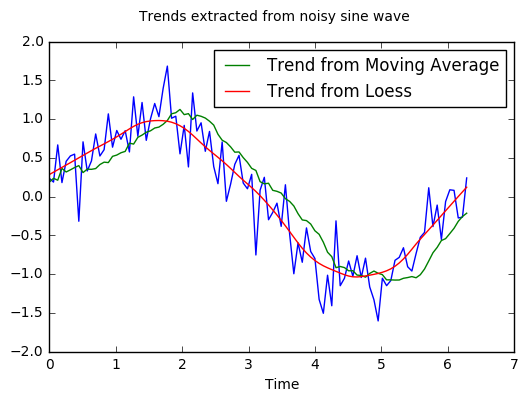

In [38]:
fig,ax = plt.subplots()
ax.plot(x,noisyWave)
ax.plot(x,trendMA, label='Trend from Moving Average')
ax.plot(x,trendL, label="Trend from Loess")
ax.set_xlabel("Time")
ax.legend()
fig.suptitle("Trends extracted from noisy sine wave")

You can see that the trend is smoother with Loess.

# Model a time series

## Moving Average model

In [39]:
SIZE = 100
ma1 = np.zeros(SIZE)
    # Generate noise
noise = np.random.standard_normal((SIZE,)) # normal distribution
    # Loop for generating MA(1) process

for i in range(0, SIZE):
    ma1[i] = noise[i] + 0.6*noise[i-1]

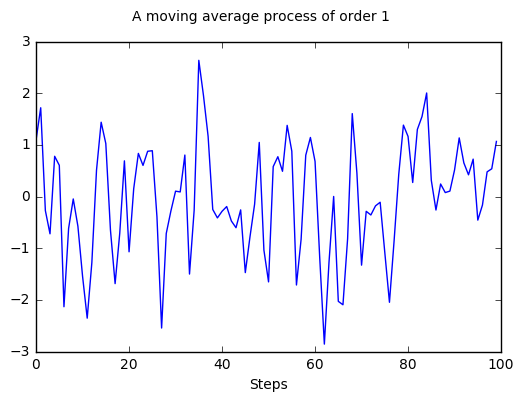

In [40]:
fig,ax = plt.subplots()
ax.plot(ma1)
ax.set_xlabel("Steps")
fig.suptitle("A moving average process of order 1");

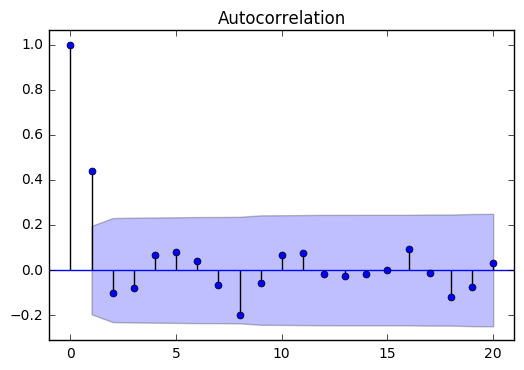

In [41]:
smpl.plot_acf(ma1, lags=20);

## MA(2) process 

In this simulation, the Xt values will depend on Ztn, Zt minus one and Zt minus two, where all of these Z noises are standard normal distribution. 

Moving average model, order 2:  
X_t = Z_t + Theta_1 * Z_t-1 + Theta2 * Zt-2   

In [42]:
SIZE = 500
ORDER = 2
ma2 = np.zeros(SIZE)
    # Generate noise
noise = np.random.standard_normal((SIZE,)) # normal distribution
    # Loop for generating MA(2) process
for i in range(ORDER, SIZE):
    ma2[i] = noise[i] + 0.7*noise[i-1] + 0.2*noise[i-2]

In the moving average process of order two, Xt depends on the noise two steps back. It depends on Zt, Zt minus 1, zt minus 2.  For clarity, I started the loop from 2 (the order), therefore it's needed to shift the resulting model by two values:

In [43]:
# Shift data to left by 2 units
moving_average_process_2 = np.roll(ma2, -ORDER)

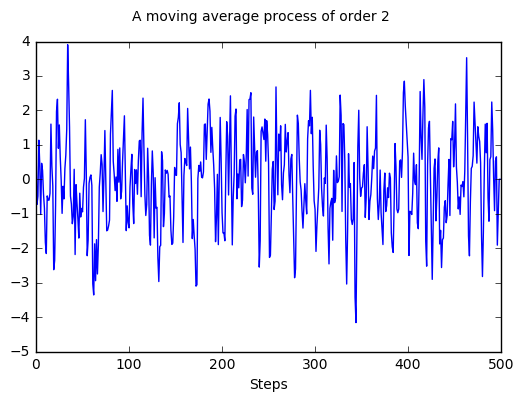

In [44]:
fig,ax = plt.subplots()
ax.plot(moving_average_process_2)
ax.set_xlabel("Steps")
fig.suptitle("A moving average process of order 2");

Here I have a moving average process of order 2. Without analyzing it, it would be impossible to tell this is actually a moving average process. 

### Correlogram of a moving average process of order 2

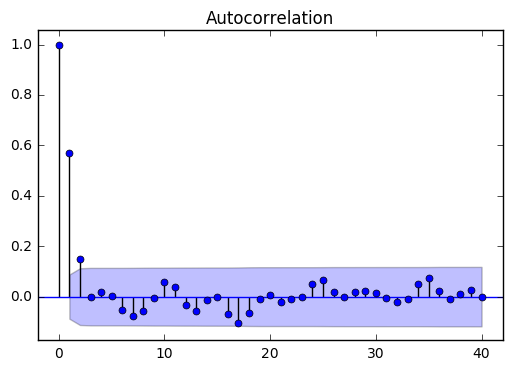

In [45]:
smpl.plot_acf(moving_average_process_2, lags=40);

As expected, MA(2) has **two** significative lages in the ACF plot.  
This can be used the other way around: if a time series has q significative lags, then it can be modeled by a MA of order q.

 So this is one of the ways we're going to model our time series later on. You're going to look at ACF and if you see an ACF cuts off after some lag, that gives us a reason to model our data using a moving average process. 

## Simulate MA(4) process 
One last example, a moving average process of order 4:

In [46]:
SIZE = 500
ORDER = 4
ma4 = np.zeros(SIZE)
    # Generate noise
noise = np.random.standard_normal((SIZE,)) # normal distribution
    # Yet another loop for generating MA(4) process :)  no shift!
for i in range(ORDER, SIZE):
    ma4[i-4] = noise[i] + 0.2*noise[i-1] + 0.3*noise[i-2] + 0.4*noise[i-3]

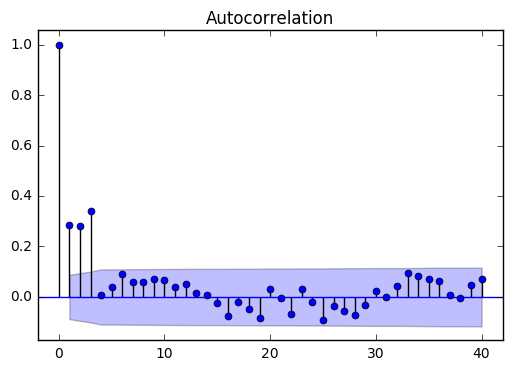

In [47]:
smpl.plot_acf(ma4, lags=40);

# Autoregressive process AR

When the dependent variable is regressed against one or more lagged values of itself the model is called autoregressive. The formula looks like this:

When you describe the "order" of the model, as in, an AR model of order "p", the p represents the number of lagged variables used within the model. For example an AR(2) model or second-order autoregressive model looks like this:

Note that an AR(1) model with alpha set equal to 1 is a random walk and therefore not stationary. 


In [48]:
SIZE = 100
ORDER = 1
beta = 1
X = np.zeros(SIZE)
    # Generate noise
W = np.random.standard_normal((SIZE,)) # noise as a normal distribution
    # Loop for generating AR1 process
#X[1] = W[1]
for t in range(ORDER, SIZE):
    X[t] = beta * X[t-1] + W[t]

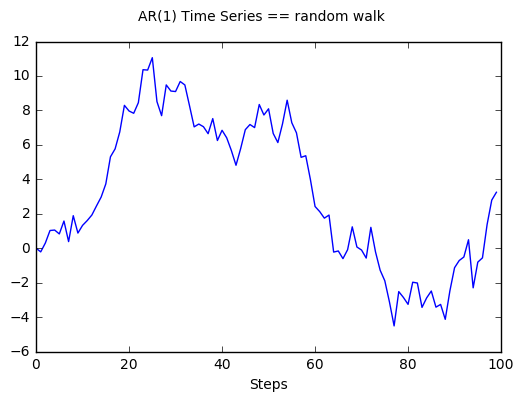

In [49]:
fig,ax = plt.subplots()
ax.plot(X)
ax.set_xlabel("Steps")
fig.suptitle("AR(1) Time Series == random walk");

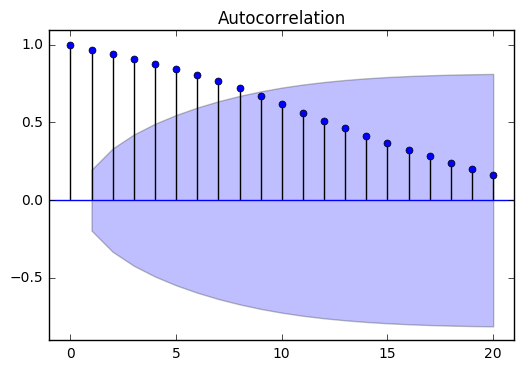

In [50]:
smpl.plot_acf(X, lags=20);

It looks like a random walk.  
An AR(1) process is only stationary when -1 < beta < 1.

In [51]:
SAMPLES = 1000
beta = 0.6
X = W = np.random.normal(size = SAMPLES)
for t in range(SAMPLES):
    X[t] = beta * X[t-1] + W[t]

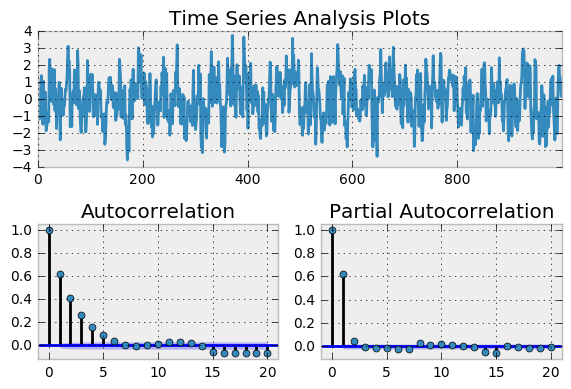

In [52]:
plotTS(X, lags=20);

As expected the distribution of our simulated AR(1) model is normal. There is significant serial correlation between lagged values but interestingly the PACF plot shows only one significant value.  
Let's try an AR(2) process.

## AR(2)

In [53]:
SAMPLES = 1000
ORDER = 2
X = W = np.random.normal(size = SAMPLES)
for t in range(SAMPLES):
    X[t] = 0.666 * X[t-1] - 0.333 * X[t-2] + W[t]

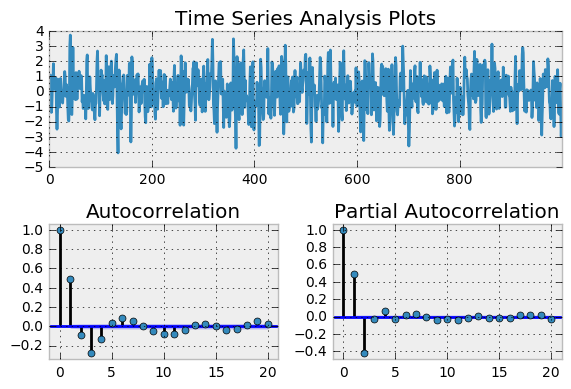

In [54]:
plotTS(X, lags=20);

As before we can see that the ACF correlogram differs significantly from that of white noise, as we'd expect.  
The PACF plot shows **two** statistically significant peaks at k=1, k=2.

Similar to the MA model and the ACF plot, here you're going to look at PACF and if you see that PACF cuts off after some lag *p*, that gives a reason to model the data using an autoregressive process with order *p*.

## ARIMA - Autoregressive Moving Average models

In [55]:
import statsmodels.tsa.arima_process as ap

In [56]:
  # AR and MA coeffs need always 1 at first
simulated = ap.arma_generate_sample(ar=[1], ma=[1], nsample=100) 

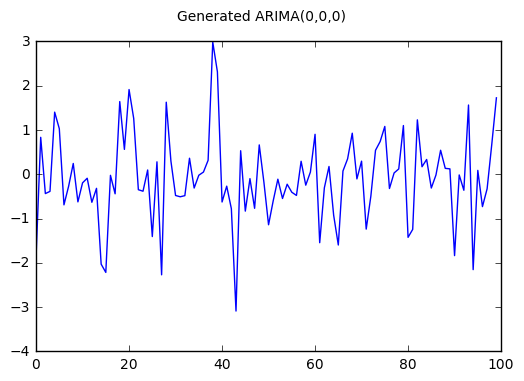

In [57]:
fig,ax = plt.subplots()
ax.plot(simulated)
fig.suptitle("Generated ARIMA(0,0,0)")

In [58]:
ar_coef = [1, -0.75, 0.25]
ma_coef = [1, .65, .35]
n = 100

In [59]:
arma_process = ap.ArmaProcess(ar_coef, ma_coef)
arma_process.isstationary

True

In [60]:
simulated = ap.arma_generate_sample(ar_coef, ma_coef, n)

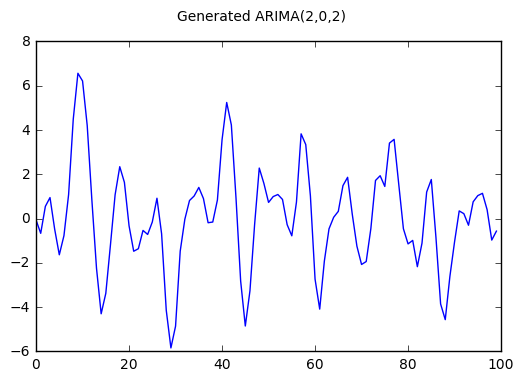

In [61]:
fig,ax = plt.subplots()
ax.plot(simulated)
fig.suptitle("Generated ARIMA(2,0,2)");

As a rule of thumb, you use the ACF for confirming trend and inferring possible values of the moving average parameters, and the PACF for the auto regressive part.

In [62]:
from statsmodels.tsa.arima_model import ARIMA

In [63]:
modelFitted = ARIMA(simulated, order=(2,0,2))

In [64]:
results = modelFitted.fit(disp=0) # disp: do not display covergence info

In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(2, 2)   Log Likelihood                -134.832
Method:                       css-mle   S.D. of innovations              0.918
Date:                Sat, 16 Jun 2018   AIC                            281.664
Time:                        14:56:50   BIC                            297.295
Sample:                             0   HQIC                           287.990
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1044      0.294      0.355      0.723      -0.472       0.681
ar.L1.y        1.0570      0.152      6.959      0.000       0.759       1.355
ar.L2.y       -0.5977      0.111     -5.398      0.000      -0.815      -0.381
ma.L1.y        0.5753      0.174      3.308      0.001       0.234       0.916
ma.L2.y        0.1602      0.204      0.786      0.434      -0.239       0.560
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8842           -0.9440j            1.2935           -0.1302
AR.2            0.8842           +0.9440j            1.2935            0.1302
MA.1           -1.7957           -1.7374j            2.4987           -0.3776
MA.2           -1.7957           +1.7374j            2.4987            0.3776
-----------------------------------------------------------------------------
"""

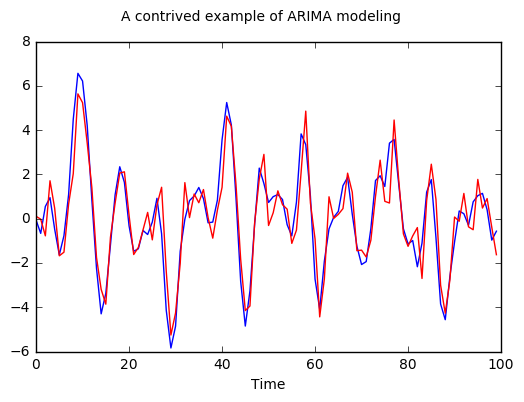

In [66]:
fig,ax = plt.subplots()
ax.plot(simulated)
ax.plot(results.fittedvalues, color='red')
ax.set_xlabel("Time")
fig.suptitle("A contrived example of ARIMA modeling");